# Python применение статистических критериев на практике - пайплайн оценки A/B

In [1]:
from scipy.stats import ttest_1samp
from scipy import stats
import numpy as np

# import warnings
# warnings.filterwarnings('ignore')
# warnings.warn('DelftStack')
# warnings.warn('Do not show this message')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import pearsonr


## Тестирование гипотез
### Гипотеза для коэффициента корреляции

In [2]:
data1 = [0.873, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]
data2 = [0.353, 3.517, 0.125, -7.545, -0.555, -1.536, 3.350, -1.578, -3.537, -1.579]
stat, p = pearsonr(data1, data2)

print('stat=%.3f, p=%.3f' % (stat, p))

print('Groups are different (reject H0)') if p < 0.05 else print('Groups are similar (fail to reject H0)')

stat=0.688, p=0.028
Groups are different (reject H0)


### Поработаем с датасетом c покупками
Метрики ARPU или Average Revenue Per User - является производным показателем, рассчитывается как средневзвешенное за период агрегации значение Платежи LT/Регистрации. Отображает прибыль, полученную нами с 1 регистрации пользователя, также известен.

ARPPU или Average Revenue Per Paying User - средний платеж платящего пользователя. Рассчитывается как средневзвешенное значение (Платежи LT/Впервые заплативших LT) за период агрегации. Показывает, сколько, в среднем, платит пользователь, ставший платящим, и, зарегистрированный в период агрегации, за всю жизнь.

### Подготовка данных

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
data = pd.read_csv('ab_stats.csv')
data.head()

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [6]:
data.shape

(23652, 5)

In [7]:
data.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


In [8]:
data.isna().sum()

revenue          0
num_purchases    0
purchase         0
ab_group         0
av_site visit    0
dtype: int64

In [9]:
data.ab_group.value_counts()

A    11835
B    11817
Name: ab_group, dtype: int64

---

In [10]:
data[data['revenue']>0]

,revenue,num_purchases,purchase,ab_group,av_site visit
45,1.885595,1,1,A,7.654627
54,1.002159,1,1,A,6.392489
82,2.990000,1,1,A,8.596604
104,49.990000,1,1,A,8.885633
110,22.093757,4,1,A,8.708759
...,...,...,...,...,...
23426,2.489611,1,1,B,9.015714
23493,74.950000,5,1,B,5.881950
23495,3.667866,1,1,B,7.450014
23584,19.990000,1,1,B,9.813696


#### Посмотрим на группы отдельно

In [11]:
data[data.ab_group == 'A'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11835.000000,11835.000000,11835.000000,11835.000000
mean,0.404462,0.050697,0.021631,6.974724
std,13.133218,1.467511,0.145481,2.023533
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.656155
50%,0.000000,0.000000,0.000000,6.982329
75%,0.000000,0.000000,0.000000,8.345572
max,1303.609284,152.000000,1.000000,17.728836


In [12]:
data[data.ab_group == 'B'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11817.000000,11817.000000,11817.000000,11817.000000
mean,0.244794,0.036473,0.019802,7.051559
std,3.176534,0.418480,0.139325,3.976799
min,0.000000,0.000000,0.000000,-8.286822
25%,0.000000,0.000000,0.000000,4.380984
50%,0.000000,0.000000,0.000000,7.060873
75%,0.000000,0.000000,0.000000,9.768648
max,113.830000,25.000000,1.000000,22.446822



Пока мы еще ничего не посчитали, но уже можно заметить, что максимальный чек в первой группе сильно больше, чем в группе B. Все мы знаем, что среднее очень неустойчиво к выбросам, так что нам необходимо будет это учесть.

### Проверка на нормальность распределения и применение статистических критериев
#### Метрика: посещения на пользователя (визиты на юзера)

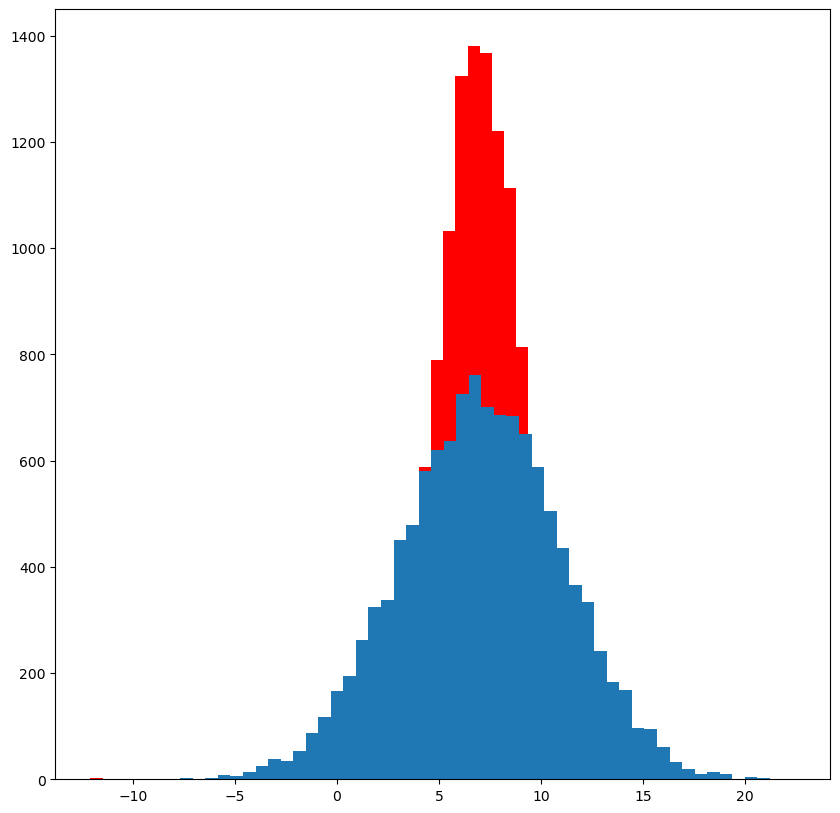

In [13]:
plt.figure(figsize=(10, 10))
control_visit_all = data['av_site visit'][data.ab_group == 'A']
test_visit_all = data['av_site visit'][data.ab_group == 'B']

plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all, bins=50)

plt.show()

In [14]:
stats.ttest_ind(control_visit_all, test_visit_all, equal_var=False)

Ttest_indResult(statistic=-1.872183970103851, pvalue=0.06119777801292236)

### Метрика: доля пользователей с покупкой

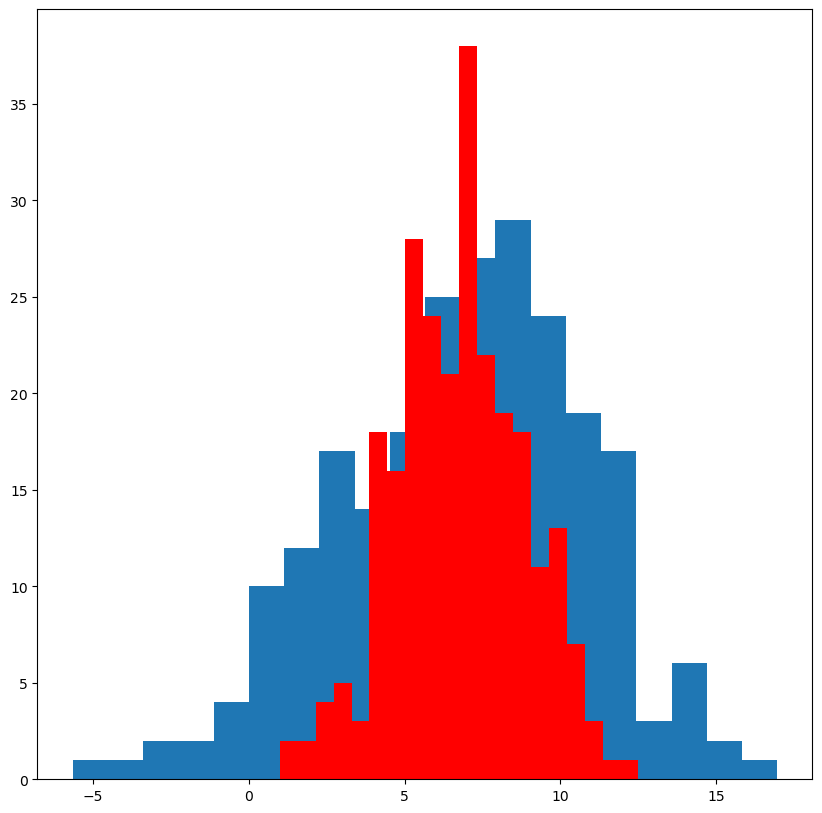

In [15]:
plt.figure(figsize=(10, 10))
control_visit = data['av_site visit'][(data['ab_group'] == 'A')&(data['purchase'] == 1)]
test_visit =data['av_site visit'][(data['ab_group'] == 'B')&(data['purchase'] == 1)]
plt.hist(test_visit,  bins=20)
plt.hist(control_visit, color='r', bins=20)

plt.show()

In [16]:
data.purchase.value_counts()

0    23162
1      490
Name: purchase, dtype: int64

In [17]:
k1 = data[data.ab_group == 'A'].purchase.sum()
k2 = data[data.ab_group == 'B'].purchase.sum()

In [18]:
n1 = data[data.ab_group == 'A'].shape[0]
n2 = data[data.ab_group == 'B'].shape[0]

In [19]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), np.array([n1, n2]))
print('Results are ', 'z-score = %.3f, p-value = %.3f'%(z_score, z_pvalue))

Results are  z-score = 0.987, p-value = 0.323


In [20]:
if abs(z_pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We have failed to reject the null hypothesis


#### Непараметрический Хи-квадрат

In [21]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                   np.array([n1, n2]))

print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))

Results are  chisq =0.975, pvalue = 0.323


In [22]:
if abs(pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We have failed to reject the null hypothesis


### Метрика ARPU (Average Revenue Per User)
#### Непараметрический критерий Манн-Уитни 

In [23]:
data.groupby('ab_group')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
ab_group,,,,,,,,
A,11835.0,0.404462,13.133218,0.0,0.0,0.0,0.0,1303.609284
B,11817.0,0.244794,3.176534,0.0,0.0,0.0,0.0,113.830000


In [24]:
mw_stats = stats.mannwhitneyu(x=data[(data['ab_group'] == 'A')].revenue.values,
                                                  y=data[(data['ab_group'] == 'B')].revenue.values)
mw_stats

MannwhitneyuResult(statistic=70054756.0, pvalue=0.3243889561742552)

#### Критерий Манна-Уитни не позволяет принять альтернативную гипотезу. Иными словами, среднее значение ARPU в двух группах примерно равно.

Посчитаем Манн-Уитни для количества покупок на пользователя:

In [25]:
mw_stats2 = stats.mannwhitneyu(x=data[(data['ab_group'] == 'A')].num_purchases.values,
                                                  y=data[(data['ab_group'] == 'B')].num_purchases.values)
mw_stats2

MannwhitneyuResult(statistic=70054599.0, pvalue=0.3249718497892071)

#### Посмотрим на пользователей среди платящих:

In [26]:
mw_stats3 = stats.mannwhitneyu(x=data[(data['ab_group'] == 'A')&(data['purchase'] == 1)]['revenue'].values,
                                                  y=data[(data['ab_group'] == 'B')&(data['purchase'] == 1)]['revenue'].values)
mw_stats3

MannwhitneyuResult(statistic=29729.5, pvalue=0.8871956616344514)

Не можем отвергнуть ни одну нулевую гипотезу, значит нет достаточной разницы между группами, чтобы выкатывать изменения.

In [27]:
import numpy as np
import pandas as pd
from scipy.stats import *
import matplotlib.pyplot as plt
from tqdm.auto import tqdm #для красивой полоски

plt.style.use('ggplot')

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

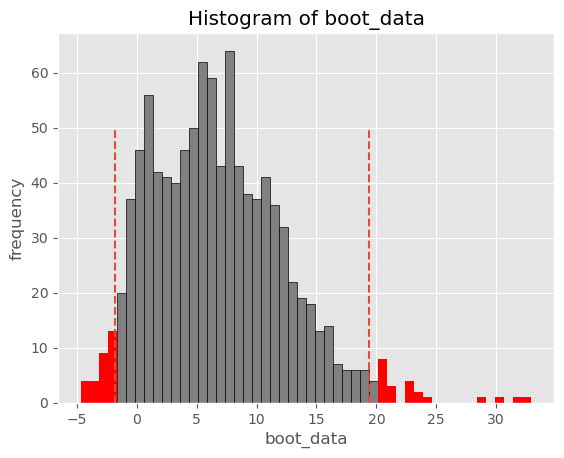

{'p_value': 0.22733135025751006}

In [28]:
get_bootstrap(data[(data['ab_group'] == 'A')&(data['purchase'] == 1)]['revenue'], data[(data['ab_group'] == 'B')&(data['purchase'] == 1)]['revenue'])

**scipy.stats**  
функция scipy.stats.bootstrap(), появившаяся с версии 1.7.0. Содержит в себе ряд аргументов, но наиболее важные таковы:

-data — данные. Принимает их на вход в виде списка (квадратные скобки) или кортежа (круглые скобки), даже если группа только одна — в случае одной группы данные подаются как (data, );  
-statistic — функция, которая считает нужный нам параметр. Если на вход идёт две или больше групп, то функция также должна принимать на вход два или больше аргументов и возвращать какое-то одно число;  
-n_resamples — количество симуляций. По умолчанию 9999 (почти 10000) - можно понизить, если не хватает вычислительных мощностей, или повысить, если хочется увеличить точность;  
-confidence_level — уровень значимости, по умолчанию 95%;
method — алгоритм расчёта доверительного интервала. Метод по умолчанию обычно справляется лучше своих аналогов, но при необходимости можно менять.   
  
**pingouin**  
В этом пакете есть функция pingouin.compute_bootci(), во многом похожая на аналогичную из scipy - но с более простым интерфейсом, рядом встроенных метрик (смотрите описание аргумента func) и немного другим набором алгоритмов бутстрапа.

**bootstrapped**  
Библиотека от Facebook, в большей степени ориентирована на применение бутстрапа в контексте индустрии. Репозиторий содержит в себе папку с ноутбуками для демонстрации всего, что умеет делать эта библиотека.

**wildboottest**  
Эта библиотека позволяет оценивать статзначимость коэффициентов регрессионной модели с помощью бутстрапа и работает вместе со statsmodels. В частности, пакет реализует алгоритм т.н. “дикого бутстрапа”, более устойчивого к нарушениям гомоскедастичности.

---

## Рассмотрим кейс с рекламной выручкой


In [29]:
df = pd.read_excel('AB_Test_Results.xlsx')
df.head()

C:\Users\natal\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [31]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [32]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [33]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

#### Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

In [39]:
from scipy import stats

In [40]:
v = df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})
v.head()

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1


In [41]:
more_than_one_types = v.query('VARIANT_NAME > 1')
df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')
df_new.shape

(6070, 3)

In [42]:
df.shape

(10000, 3)

In [43]:
control = df_new.query('VARIANT_NAME == "control"')
test = df_new.query('VARIANT_NAME == "variant"')
len(control), len(test)

(3026, 3044)

In [44]:
alpha = 0.05
st = stats.shapiro(df_new.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));

Distribution is not normal



C:\Users\natal\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


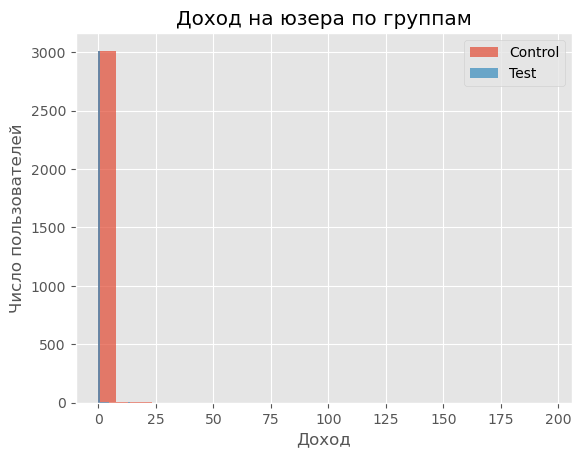

In [45]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

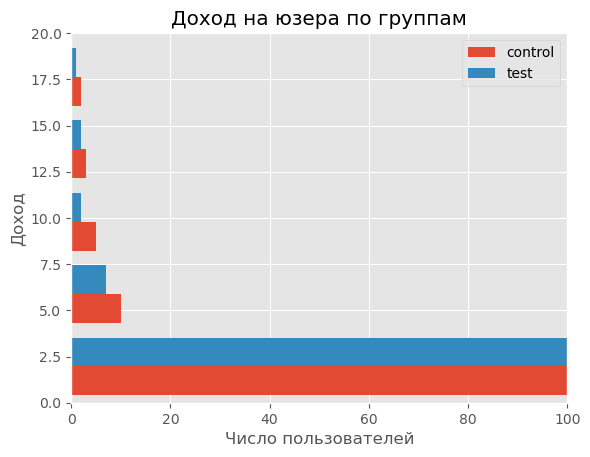

In [46]:
plt.hist([control.REVENUE, test.REVENUE], bins = 50, orientation='horizontal')
ax = plt.gca()
ax.set_ylim([0, 20])
ax.set_xlim([0, 100])
plt.title('Доход на юзера по группам')
plt.ylabel('Доход')
plt.xlabel('Число пользователей')
plt.legend(labels=['control', 'test']);

In [47]:
mw_stats4 = stats.mannwhitneyu(x=control.REVENUE.values, y=test.REVENUE.values)
mw_stats4

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

Статистически значимой разницы нет.

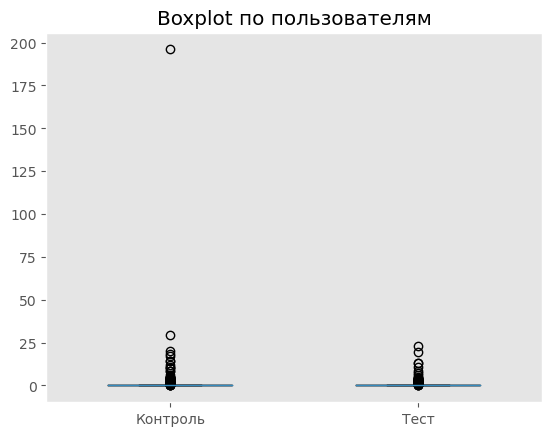

In [48]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

Очень сильный разброс данных, попробуем ограничить

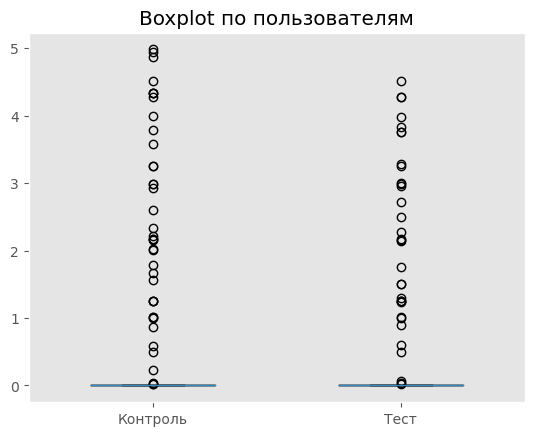

In [49]:
plt.boxplot([control.REVENUE[control.REVENUE <5],test.REVENUE[test.REVENUE < 5]],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [50]:
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.403762252371675, pvalue=0.1604844017690842)

### Расчет мощности
$$d = \frac{M_1 – M_2}{S_{pooled}}$$

$$S_{pooled} = \sqrt{\frac{{s_1}^2 + {s_2}^2}{2}}$$

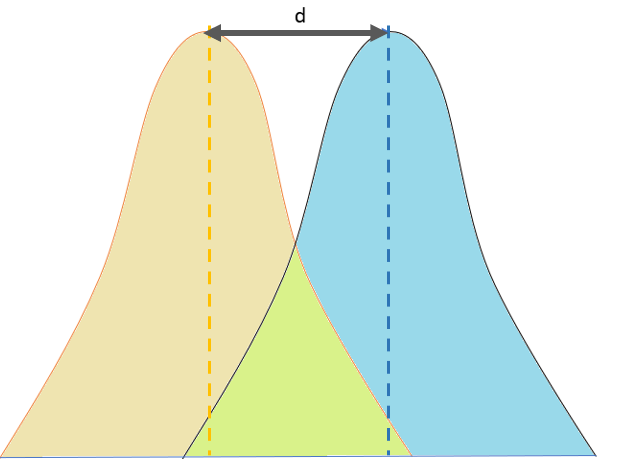

In [51]:
C_mean = control.REVENUE.values.mean()
T_mean = test.REVENUE.values.mean()

C_std = control.REVENUE.values.std()
T_std = test.REVENUE.values.std()

In [52]:
print(len(control.REVENUE.values), len(test.REVENUE.values))

3026 3044


In [53]:
n =  len(control.REVENUE.values)

In [54]:
##S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c))

S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [55]:
ef =float((T_mean-C_mean)/ S) 

In [56]:
from statsmodels.stats import power
# parameters for power analysis

alpha = 0.05

# perform power analysis
analysis = power.TTestIndPower()
result = analysis.solve_power(ef, power=None, nobs1=n, ratio=1.0, alpha=alpha)

result

0.28936707257547545

## Задача 1
Оцените результаты эксперимента :
Стат значимо ли отличается ARPU в двух группах ? Какие рекомендации дадите менеджеру?


In [57]:
data.head()

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [59]:
data.ab_group.value_counts()

A    11835
B    11817
Name: ab_group, dtype: int64

In [60]:
data.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


In [61]:
data.purchase = data.purchase.astype('uint8')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  uint8  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(1), object(1), uint8(1)
memory usage: 762.3+ KB


In [62]:
v2a = data[(data['av_site visit'] < 0) & (data.ab_group == "A")]
v2a

,revenue,num_purchases,purchase,ab_group,av_site visit
1789,0.0,0,0,A,-12.073486
1856,0.0,0,0,A,-0.683411
5122,0.0,0,0,A,-0.045455
7109,0.0,0,0,A,-12.073486
8118,0.0,0,0,A,-0.126946
9770,0.0,0,0,A,-0.045455


In [63]:
v2b = data[(data['av_site visit'] < 0) & (data.ab_group == "B")]
v2b

,revenue,num_purchases,purchase,ab_group,av_site visit
11866,0.0,0,0,B,-1.403294
11960,0.0,0,0,B,-1.312672
11970,0.0,0,0,B,-0.980742
12018,0.0,0,0,B,-0.048983
12067,0.0,0,0,B,-0.097441
...,...,...,...,...,...
23567,0.0,0,0,B,-3.901748
23606,0.0,0,0,B,-2.284448
23626,0.0,0,0,B,-3.528928
23634,0.0,0,0,B,-1.708265


In [64]:
462/11817

0.039096217314039096

In [65]:
11835*0.039 - 6

455.565

In [66]:
data2 = data
data2.head()

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814


In [67]:
data2.rename(columns={"av_site visit": "av_time"}, inplace=True)
data2.head()

,revenue,num_purchases,purchase,ab_group,av_time
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814


In [68]:
data2.drop(data2[data2.av_time < 0].index, inplace=True)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23184 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23184 non-null  float64
 1   num_purchases  23184 non-null  int64  
 2   purchase       23184 non-null  uint8  
 3   ab_group       23184 non-null  object 
 4   av_time        23184 non-null  float64
dtypes: float64(2), int64(1), object(1), uint8(1)
memory usage: 928.3+ KB


In [69]:
data2.drop(data2[data2.ab_group == 'A'].sample(456).index, inplace=True)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22728 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        22728 non-null  float64
 1   num_purchases  22728 non-null  int64  
 2   purchase       22728 non-null  uint8  
 3   ab_group       22728 non-null  object 
 4   av_time        22728 non-null  float64
dtypes: float64(2), int64(1), object(1), uint8(1)
memory usage: 910.0+ KB


In [70]:
data2.describe()

,revenue,num_purchases,purchase,av_time
count,22728.000000,22728.000000,22728.000000,22728.000000
mean,0.329282,0.044131,0.020723,7.194276
std,9.737203,1.099941,0.142460,2.941067
min,0.000000,0.000000,0.000000,0.008679
25%,0.000000,0.000000,0.000000,5.301909
50%,0.000000,0.000000,0.000000,7.076976
75%,0.000000,0.000000,0.000000,8.927703
max,1303.609284,152.000000,1.000000,22.446822


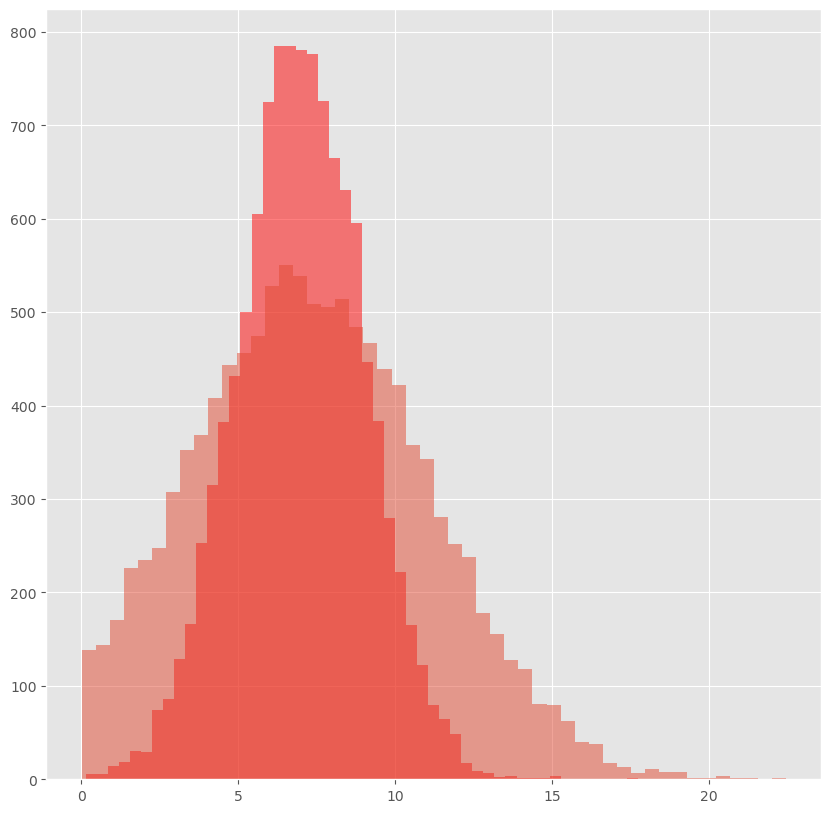

In [71]:
plt.figure(figsize=(10, 10))
control_visit_all = data2['av_time'][data2.ab_group == 'A']
test_visit_all = data2['av_time'][data2.ab_group == 'B']

plt.hist(control_visit_all, color='r', bins=50, alpha=0.5)
plt.hist(test_visit_all, bins=50, alpha=0.5)

plt.show();

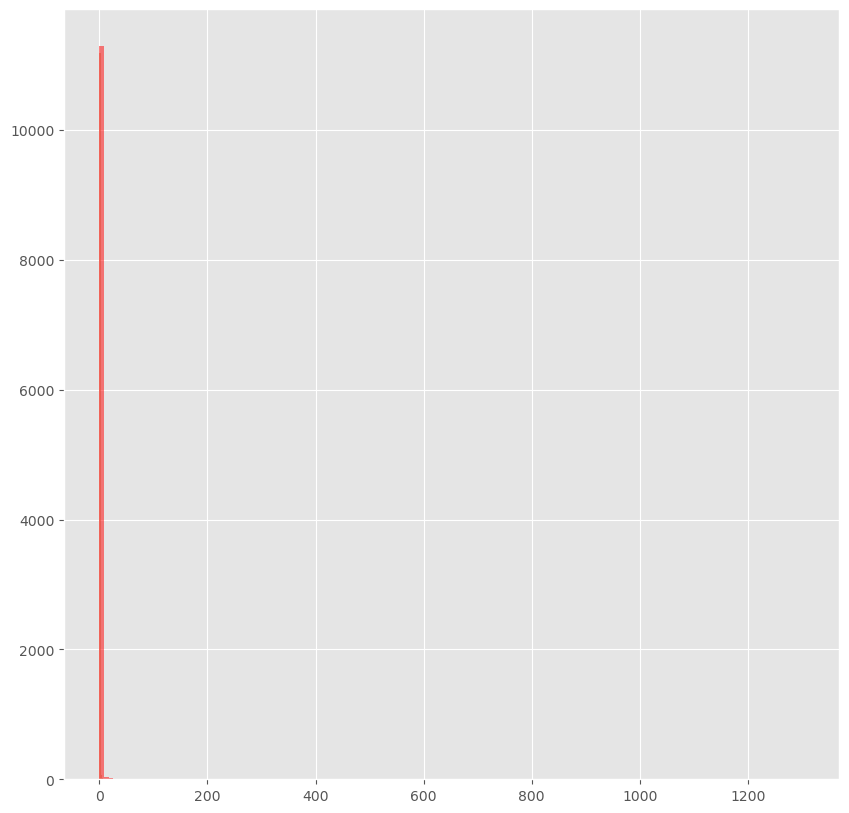

In [72]:
plt.figure(figsize=(10, 10))
control_rev = data2['revenue'][data2.ab_group == 'A']
test_rev = data2['revenue'][data2.ab_group == 'B']

plt.hist(control_rev, color='r', bins=150, alpha=0.5)
plt.hist(test_rev, bins=50, alpha=0.5)

plt.show();

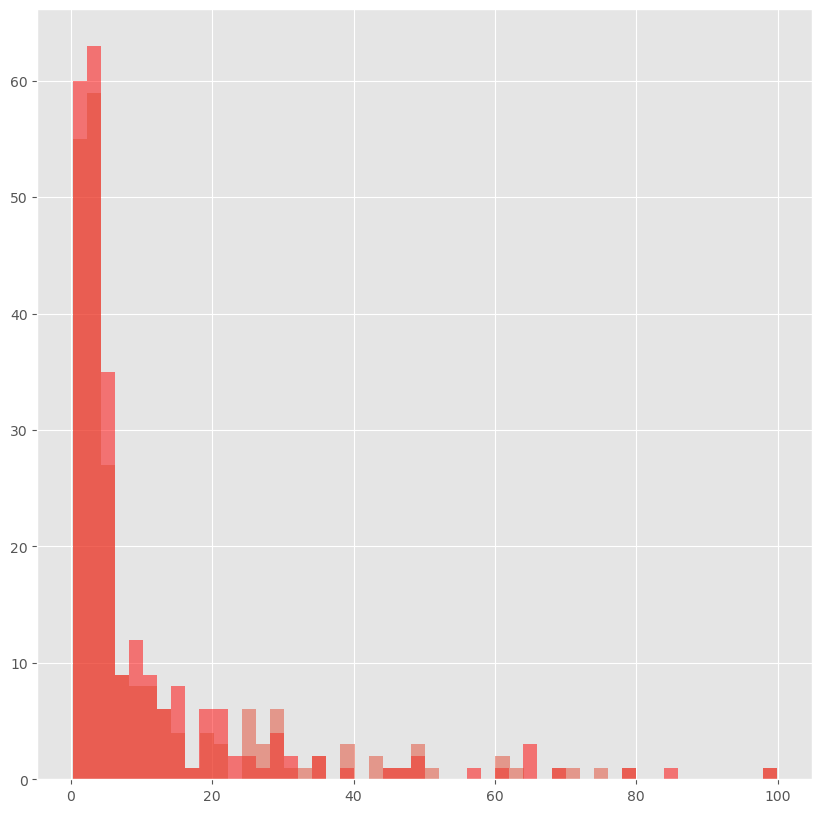

In [73]:
plt.figure(figsize=(10, 10))
control_rev = data2['revenue'][(data2.ab_group == 'A') & (data2.revenue > 0)  & (data2.revenue < 100)]
test_rev = data2['revenue'][(data2.ab_group == 'B') & (data2.revenue > 0) & (data2.revenue < 100)]

plt.hist(control_rev, color='r', bins=50, alpha=0.5)
plt.hist(test_rev, bins=50, alpha=0.5)

plt.show();

In [74]:
mw_stats5 = stats.mannwhitneyu(x=data2[(data2['ab_group'] == 'A')].revenue.values,
                                                  y=data2[(data2['ab_group'] == 'B')].revenue.values)
mw_stats5

MannwhitneyuResult(statistic=64698564.5, pvalue=0.2929144577028968)

In [75]:
data2[(data2.revenue == 0) | (data2.revenue > 100)]

,revenue,num_purchases,purchase,ab_group,av_time
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
...,...,...,...,...,...
23647,0.0,0,0,B,10.207152
23648,0.0,0,0,B,5.148761
23649,0.0,0,0,B,4.809019
23650,0.0,0,0,B,8.127488


In [76]:
data2.drop(data2[(data2.revenue <= 0) | (data2.revenue > 100)].index, inplace=True)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464 entries, 45 to 23616
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        464 non-null    float64
 1   num_purchases  464 non-null    int64  
 2   purchase       464 non-null    uint8  
 3   ab_group       464 non-null    object 
 4   av_time        464 non-null    float64
dtypes: float64(2), int64(1), object(1), uint8(1)
memory usage: 18.6+ KB


In [77]:
data2.ab_group.value_counts()

A    242
B    222
Name: ab_group, dtype: int64

In [78]:
mw_stats6 = stats.mannwhitneyu(x=data2[(data2['ab_group'] == 'A')].revenue.values,
                                                  y=data2[(data2['ab_group'] == 'B')].revenue.values)
mw_stats6

MannwhitneyuResult(statistic=26334.5, pvalue=0.7148139691438251)

#### Гипотеза 0 не может быть отвергнута. Тест показал, что группы примерно равны.